In [207]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.optim as optim
from IPython.display import clear_output

import os
from skimage import io, transform
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [28]:
!ls

class_map.csv		   test_image_data_3.parquet
OCR.ipynb		   train.csv
sample_submission.csv	   train_image_data_0.parquet
test.csv		   train_image_data_1.parquet
test_image_data_0.parquet  train_image_data_2.parquet
test_image_data_1.parquet  train_image_data_3.parquet
test_image_data_2.parquet


In [29]:
df_train_0 = pd.read_parquet("train_image_data_0.parquet")
df_train_1 = pd.read_parquet("train_image_data_1.parquet")
df_train_2 = pd.read_parquet("train_image_data_2.parquet")
df_train_3 = pd.read_parquet("train_image_data_3.parquet")

# df_train = pd.concat([df_train_0], axis=0)
df_train = pd.concat([df_train_0, df_train_1, df_train_2, df_train_3], axis=0)

In [30]:
del df_train_0
del df_train_1
del df_train_2
del df_train_3

In [5]:
print(df_train.shape)
df_train.head()

(50210, 32333)


,image_id,0,1,2,3,4,5,6,7,8,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Train_0,254,253,252,253,251,252,253,251,251,...,253,253,253,253,253,253,253,253,253,251
1,Train_1,251,244,238,245,248,246,246,247,251,...,255,255,255,255,255,255,255,255,255,254
2,Train_2,251,250,249,250,249,245,247,252,252,...,254,253,252,252,253,253,253,253,251,249
3,Train_3,247,247,249,253,253,252,251,251,250,...,254,254,254,254,254,253,253,252,251,252
4,Train_4,249,248,246,246,248,244,242,242,229,...,255,255,255,255,255,255,255,255,255,255


In [6]:
h = 137
w = 236

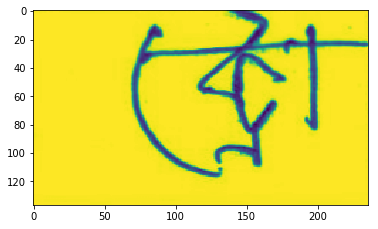

In [7]:
plt.imshow(df_train.iloc[0, 1:].values.reshape(h,w).astype(np.float32))

In [512]:
df_train_csv = pd.read_csv("train.csv")
df_train_class_map = pd.read_csv("class_map.csv")

In [15]:
print(df_train_csv.shape)
df_train_csv.head()

(200840, 5)


,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [16]:
print(df_train_class_map.shape)
df_train_class_map.head()

(186, 3)


,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই


### Check min-max of values

In [22]:
df_train_csv.describe()

,grapheme_root,vowel_diacritic,consonant_diacritic
count,200840.000000,200840.000000,200840.000000
mean,86.415604,3.357757,1.277624
std,44.289815,3.075717,1.872504
min,0.000000,0.000000,0.000000
25%,53.000000,1.000000,0.000000
50%,85.000000,2.000000,0.000000
75%,123.000000,7.000000,2.000000
max,167.000000,10.000000,6.000000


In [23]:
df_train_csv["grapheme_root"].value_counts()

72     5736
64     5596
13     5420
107    5321
23     5149
96     4926
113    4395
147    4392
133    4374
115    4015
53     3690
43     3630
103    3461
79     3458
81     3438
38     3354
159    3281
22     2961
71     2936
29     2780
56     2688
149    2402
59     2339
89     2313
122    2313
139    2312
150    2311
124    2188
86     2094
123    2073
       ... 
146     302
78      293
82      292
37      285
19      278
34      276
5       175
26      171
87      168
163     165
164     164
104     160
126     159
108     158
8       157
7       153
10      152
105     151
11      151
114     150
63      149
0       147
12      146
1       145
45      144
130     144
158     143
102     141
33      136
73      130
Name: grapheme_root, Length: 168, dtype: int64

In [24]:
df_train_csv["vowel_diacritic"].value_counts()

0     41508
1     36886
7     28723
2     25967
4     18848
3     16152
9     16032
5      5297
6      4336
10     3563
8      3528
Name: vowel_diacritic, dtype: int64

In [25]:
df_train_csv["consonant_diacritic"].value_counts()

0    125278
2     23465
5     21397
4     21270
1      7424
6      1387
3       619
Name: consonant_diacritic, dtype: int64

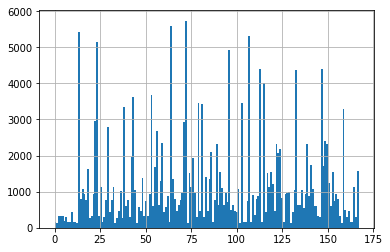

In [26]:
df_train_csv["grapheme_root"].hist(bins=168)

### Not everything is fairly distributed but since we have lots of data, we'll live. Hopefully

### Check categorical correlation?

In [ ]:
# for i in range(len(df_train)):
#     im = Image.fromarray(df_train.iloc[i, 1:].values.reshape(h,w).astype(np.uint8))
#     im.save("data/train/" + df_train.iloc[i, 0]+".jpg")

In [ ]:
del df_train

In [87]:
class BengaliCharactersDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.info_csv = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.info_csv)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir,
                                self.info_csv.iloc[idx, 0])
        image = io.imread(img_name+".jpg")
        if self.transform:
            image = self.transform(image)
        components = self.info_csv.iloc[idx, 1:4]
        components = torch.tensor([components])
        sample = {'image': image, 'components': components}

        return sample

In [88]:
data_transform = transforms.Compose([
        transforms.ToTensor()
    ])

In [89]:
train_dataset = BengaliCharactersDataset(csv_file='train.csv', root_dir='data/train/', transform = data_transform)

0 torch.Size([1, 137, 236]) torch.Size([1, 3])
1 torch.Size([1, 137, 236]) torch.Size([1, 3])
2 torch.Size([1, 137, 236]) torch.Size([1, 3])
3 torch.Size([1, 137, 236]) torch.Size([1, 3])


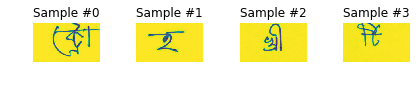

In [92]:
fig = plt.figure()

for i in range(len(train_dataset)):
    sample = train_dataset[i]

    print(i, sample['image'].shape, sample['components'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'].squeeze())

    if i == 3:
        plt.show()
        break

In [102]:
loader = DataLoader(
    train_dataset,
    batch_size=10,
    num_workers=1,
    shuffle=False
)


mean = 0.
std = 0.
nb_samples = 0.
cnt=0
for merged_data in loader:
    cnt+=1
    data = merged_data['image']
#     print(batch_samples.shape)
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples
    if cnt%1000==0:
        print(cnt)

mean /= nb_samples
std /= nb_samples
print("mean = ", mean, "std = ", std)

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fa4098dbb38>>
Traceback (most recent call last):
  File "/home/abhisheknan/anaconda3/envs/dlenv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/abhisheknan/anaconda3/envs/dlenv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/abhisheknan/anaconda3/envs/dlenv/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fa4098d09e8>>
Traceback (most recent call last):
  File "/home/abhisheknan/anaconda3/envs/dlenv/lib/python3.6

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
mean =  tensor([0.9469]) std =  tensor([0.1623])


In [285]:
data_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224,224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.9469, 0.9469, 0.9469],
                             std=[0.1623, 0.1623, 0.1623]),
    ])

In [286]:
train_dataset = BengaliCharactersDataset(csv_file='train.csv', root_dir='data/train/', transform = data_transform)

In [499]:
dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=10)

In [500]:
for i in dataloader:
    print(i['image'].shape)
    print(i['components'].shape)
    break

torch.Size([10, 3, 224, 224])
torch.Size([10, 1, 3])


In [501]:
class AppendNet(nn.Module):
    def __init__(self):
        super(AppendNet, self).__init__()
        self.start = nn.Linear(1000, 1000)
        self.fc_root = nn.Linear(1000, 168)
        self.fc_vowel = nn.Linear(1000, 11)
        self.fc_consonant = nn.Linear(1000, 7)
    
    def forward(self, x):
        root_prob = self.fc_root(F.relu(self.start(x)))
        vowel_prob = self.fc_vowel(F.relu(self.start(x)))
        consonant_prob = self.fc_consonant(F.relu(self.start(x)))
        return root_prob, vowel_prob, consonant_prob

In [502]:
vgg = models.vgg11(True)
for param in vgg.parameters():
    param.requires_grad = False

In [503]:
CustomNet = nn.Sequential(vgg, AppendNet()).to(device)

In [504]:
criterion = nn.CrossEntropyLoss()

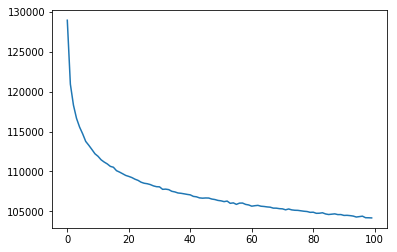

In [505]:
loss1_list = []
loss2_list = []
loss3_list = []
cnt=0

params_to_update = []
for name,param in CustomNet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = optim.Adam(params_to_update, lr=1e-4, amsgrad=True)
loss_list=[]
for epoch in range(100):
    running_loss = 0
    for i in dataloader:
        CustomNet.train()
        cnt+=1
        optimizer.zero_grad()
        test_out = CustomNet(i['image'].to(device))
        loss1 = criterion(test_out[0], i['components'][:,:,0].squeeze(1).to(device))
        loss2 = criterion(test_out[1], i['components'][:,:,1].squeeze(1).to(device))
        loss3 = criterion(test_out[2], i['components'][:,:,2].squeeze(1).to(device))
        loss = loss1+loss2+loss3
    #     loss1_list.append(loss1.item())
    #     loss2_list.append(loss2.item())
    #     loss3_list.append(loss3.item())


    #     loss1.backward(retain_graph=True)
    #     loss2.backward(retain_graph=True)
    #     loss3.backward()
        loss.backward()
        running_loss+=loss.item()
        optimizer.step()
    clear_output(wait=True)
#     plt.plot(loss1_list)
#     plt.plot(loss2_list)
#     plt.plot(loss3_list)
    loss_list.append(running_loss)
    plt.plot(loss_list)
    plt.show()
        

In [496]:
CustomNet.eval()
print(torch.argmax(CustomNet(train_dataset[0]['image'].unsqueeze(0).to(device))[0]))
print(torch.argmax(CustomNet(train_dataset[0]['image'].unsqueeze(0).to(device))[1]))
print(torch.argmax(CustomNet(train_dataset[0]['image'].unsqueeze(0).to(device))[2]))
print(train_dataset[0]['components'])

tensor(59, device='cuda:0')
tensor(10, device='cuda:0')
tensor(3, device='cuda:0')
tensor([[15,  9,  5]])


In [506]:
CustomNet.eval()
print(torch.argmax(CustomNet(train_dataset[0]['image'].unsqueeze(0).to(device))[0]))
print(torch.argmax(CustomNet(train_dataset[0]['image'].unsqueeze(0).to(device))[1]))
print(torch.argmax(CustomNet(train_dataset[0]['image'].unsqueeze(0).to(device))[2]))
print(train_dataset[0]['components'])

tensor(80, device='cuda:0')
tensor(9, device='cuda:0')
tensor(0, device='cuda:0')
tensor([[15,  9,  5]])


In [507]:
df_train_csv

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো
5,Train_5,153,9,0,স্পো
6,Train_6,52,2,0,ঞ্জি
7,Train_7,139,3,0,ষী
8,Train_8,67,0,0,ত্থ
9,Train_9,64,7,1,তেঁ


In [513]:
X = df_train_csv.pop('image_id').to_frame()
df_train_csv.pop('grapheme')
y = df_train_csv

In [521]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
        X, y,stratify=y, test_size=0.2)

In [522]:
y_train["grapheme_root"].value_counts()

72     4588
64     4477
13     4333
107    4258
23     4121
96     3943
147    3517
113    3515
133    3495
115    3210
53     2952
43     2906
103    2770
79     2767
81     2749
38     2683
159    2626
22     2367
71     2350
29     2223
56     2149
149    1923
59     1870
122    1851
89     1850
150    1850
139    1848
124    1751
86     1676
123    1659
       ... 
146     242
78      234
82      234
37      228
19      222
34      221
5       140
26      137
87      134
163     132
164     131
104     128
126     127
108     126
8       126
7       123
10      122
105     121
11      121
114     120
63      119
0       118
12      117
1       116
45      115
130     115
158     115
102     113
33      109
73      104
Name: grapheme_root, Length: 168, dtype: int64